In [1]:
using PorousMaterials
using JLD2
using PyPlot
using PyCall
using CSV
using DataFrames

# config plot settings
PyPlot.matplotlib.style.use("ggplot")
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [2]:
###
#  read in lines to get COF filenames
###
filename = joinpath(pwd(), "./descriptors/cof_names.txt")
cof_name_file = open(filename)
cof_names = readlines(cof_name_file)
close(cof_name_file)

###
#  load properties
###
chem_props_filename = joinpath(pwd(), "descriptors/chemical_properties.csv")
geo_props_filename  = joinpath(pwd(), "descriptors/geometric_properties.csv")

chemical_properties  = CSV.read(chem_props_filename, DataFrame)
geometric_properties = CSV.read(geo_props_filename, DataFrame)

descriptors = outerjoin(geometric_properties, chemical_properties, on=["crystal_name"]);
names(descriptors)

15-element Vector{String}:
 "crystal_name"
 "pore_diameter_Å"
 "void_fraction"
 "surface_area_m²g⁻¹"
 "crystal_density"
 "density_of_Carbon"
 "density_of_Hydrogen"
 "density_of_Oxygen"
 "density_of_Nitrogen"
 "density_of_Silicon"
 "density_of_Sulfur"
 "density_of_Boron"
 "density_of_Phosphorus"
 "density_of_Halogens"
 "density_of_Metals"

In [3]:
# for some reason these ones aren't working... LOOk INTO IT
skip_for_now = ["07012N3_ddec.cif", "16290N3_ddec.cif", "21111N3_ddec.cif"]
[delete!(descriptors, findfirst(descriptors[:, "crystal_name"] .== name)) for name in skip_for_now];

In [4]:
###
#  simulation parameters
###
adsorbates = Molecule.(["Kr", "Xe"])
mole_fxn   = [0.8, 0.2] # [Kr, Xe]
total_pressure = 1.0    # bar
partial_pressures = total_pressure * mole_fxn

temperature = 298.0 # K
ljff = LJForceField("UFF")
nb_ins_per_vol = 500
nb_cyc_per_vol = 150

benchmarked_cofs = ["05000N2_ddec.cif", "17156N2_ddec.cif"]

2-element Vector{String}:
 "05000N2_ddec.cif"
 "17156N2_ddec.cif"

## Calculate Error in Selectivity from Henry Coefficient:
We have the Henry coefficients $ H_{Xe} = h_{Xe} \pm \delta h_{Xe} $, $ H_{Kr} = h_{Kr} \pm \delta h_{Kr}$,  where $h_j$ is the "measured" value and $\delta h_j$ is the associated uncertainty. The Selectivity is calculated as $ S_{Xe/Kr} = s_i \pm \delta s_i$ where $s_i = \frac{h_{Xe}}{h_{Kr}}$. 

To determine the uncertainty of the selectivity $\delta s_i$, we use the fact that the relative errors add in quaderature:
$$ \left(\frac{\delta s_i}{s_i}\right)^2 = \left( \frac{\delta h_{Xe}}{h_{Xe}} \right)^2 + \left( \frac{\delta h_{Kr}}{h_{Kr}} \right)^2  $$

So, 
$$ \delta s_i = s_i\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{\delta h_{Kr}}{h_{Kr}}\right)}^2 } $$

Substituting in the expression for $s_i$, we get:
$$ S_{Xe/Kr} = \frac{h_{Xe}}{h_{Kr}} \pm \frac{h_{Xe}}{h_{Kr}}\sqrt{ {\left( \frac{\delta h_{Xe}}{h_{Xe}} \right)}^2 + {\left(\frac{ \delta h_{Kr}}{h_{Kr}}\right)}^2 }$$


Note: For GCMC, replace the henry coefficient (H) with the amount adsorbed by each species (N_i) and multiply by the mole fraction. 

In [5]:
function calculate_selectivity(gdf::GroupedDataFrame{DataFrame}, 
                               gas1::String, gas2::String; 
                               is_henry::Bool=false)
    df1 = [df for df in gdf if all(String.(df[:, "adsorbate"]) .== gas1)]
    df2 = [df for df in gdf if all(String.(df[:, "adsorbate"]) .== gas2)]
    
    if is_henry
        uptake_col_name = "henry coefficient [mmol/(g-bar)]"
        err_col_name = "err henry coefficient [mmol/(g-bar)]"
        # set default value for mole fraction
        fxn1 = ones(length(df1[1][:, "xtal"]))
        fxn2 = ones(length(df2[1][:, "xtal"]))
    else
        uptake_col_name = "⟨N⟩ (mmol/g)"
        err_col_name = "err ⟨N⟩ (mmol/g)"
        # need mole fractions for GCMC Selectivity
        fxn1 = df1[1][:, "pressure (bar)"]
        fxn2 = df2[1][:, "pressure (bar)"]
    end
    
    h1  = df1[1][:, uptake_col_name]
    dh1 = df1[1][:, err_col_name]
    h2  = df2[1][:, uptake_col_name]
    dh2 = df2[1][:, err_col_name]
    
    s = (h1 ./ fxn1) ./ (h2 ./ fxn2)
    s_err = s .* sqrt.((dh1 ./ h1) .^ 2 + (dh2 ./ h2) .^ 2)
    
    df = DataFrame()
    for (i, name) in enumerate(df1[1][:, "xtal"])
        for gas in [gas1, gas2]
            dict = Dict("xtal" => name,
                        "adsorbate" => gas,
                        "selectivity " * gas1 * "/" * gas2 => s[i],
                        "err selectivity " * gas1 * "/" * gas2 => s_err[i])

            df = vcat(df, DataFrame(dict))
        end
    end
    return df
end

calculate_selectivity (generic function with 1 method)

In [6]:
function get_henry_data(cof_names::Array{String, 1}, 
                        adsorbates::Array{Molecule{Cart}, 1};
                        calculate_selectivity::Bool=true,
                        selectivity_species::Union{Nothing, Array{Symbol, 1}}=nothing)
    # initialize data structure to store results
    henry_df = DataFrame()
    
    # loop over every material
    for cof_name in cof_names
        xtal = Crystal(cof_name; check_neutrality=false)
        if xtal.name in skip_for_now
            continue
        end
        # get results dictionary for each material, adsorbate pair
        for molecule in adsorbates
            # get filename 
            henry_filename = henry_result_savename(xtal, molecule, temperature, ljff, nb_ins_per_vol)
            # load results dictionary from file
            @load joinpath(PorousMaterials.rc[:paths][:simulations], henry_filename) results
            # include adsorbate (probe) species in results dict
            res = deepcopy(results) # don't want to modify original dict
            res["adsorbate"] = String(molecule.species)
            # add to dataframe
            henry_df = vcat(henry_df, DataFrame(res))
        end
    end
    return henry_df
end

get_henry_data (generic function with 1 method)

In [7]:
function calculate_num_burn_and_sample_cycles(xtal::Crystal, cycles_per_volume::Int64; 
                                              fraction_burn_cycles::Float64=0.5)
    nb_cycles = max(5, ceil(Int, cycles_per_volume * xtal.box.Ω))
    @assert (0.0 < fraction_burn_cycles) && (fraction_burn_cycles < 1.0) 
    n_burn_cycles   = ceil(Int, nb_cycles * fraction_burn_cycles)
    n_sample_cycles = ceil(Int, nb_cycles * (1 - fraction_burn_cycles))
    return n_burn_cycles, n_sample_cycles
end

function get_gcmc_data(cof_names::Array{String, 1}, 
                        adsorbates::Array{Molecule{Cart}, 1};
                        calculate_selectivity::Bool=true)
    # initialize data structure to store results
    gcmc_df = DataFrame()
    
    # loop over every material
    for cof_name in cof_names
        xtal = Crystal(cof_name; check_neutrality=false)
        if xtal.name in skip_for_now
            continue
        end
        n_burn, n_sample = calculate_num_burn_and_sample_cycles(xtal, nb_cyc_per_vol)
        gcmc_filename = μVT_output_filename(xtal, adsorbates, temperature, 
                                            partial_pressures, ljff, n_burn, n_sample)
        @load joinpath(PorousMaterials.rc[:paths][:simulations], gcmc_filename) results
        
        res = deepcopy(results)
        res["adsorbate"] = String.(res["adsorbate"])
        gcmc_df = vcat(gcmc_df, DataFrame(res))
    end
    return gcmc_df
end

get_gcmc_data (generic function with 1 method)

In [8]:
hdf = get_henry_data(cof_names, adsorbates)
gr_hdf = groupby(hdf, "adsorbate")
henry_selectivity = calculate_selectivity(groupby(hdf, "adsorbate"), "Xe", "Kr"; is_henry=true)
henry_data = outerjoin(hdf, henry_selectivity, on=["xtal", "adsorbate"])
CSV.write(joinpath(pwd(), "henry_calculations.csv"), henry_data)
gr_henry_data = groupby(henry_data, "adsorbate")

,Qst (kJ/mol),adsorbate,elapsed time (min),err Qst (kJ/mol),err henry coefficient [mmol/(g-bar)]
,Float64?,String?,Float64?,Float64?,Float64?
1,21.329,Kr,1.80109,0.131795,0.0214178
2,10.6927,Kr,5.61557,0.0150828,0.00165314
3,9.9699,Kr,4.40649,0.0122787,0.00161386
4,17.0255,Kr,1.84388,0.0188006,0.012399
5,11.5299,Kr,3.25362,0.0191455,0.00248071
6,9.85127,Kr,27.8586,0.00223396,0.000429852
7,9.21427,Kr,7.60895,0.00164926,0.000391604
8,6.79193,Kr,3.87627,0.00566888,0.000524744
9,12.8257,Kr,14.3257,0.00264895,0.000883062


In [9]:
gdf = get_gcmc_data(cof_names, adsorbates)
gr_gdf = groupby(gdf, "adsorbate")
gcmc_selectivity = calculate_selectivity(gr_gdf, "Xe", "Kr")
gcmc_data = outerjoin(gdf, gcmc_selectivity, on=["xtal", "adsorbate"])
CSV.write(joinpath(pwd(), "gcmc_calculations.csv"), gcmc_data)
gr_gcmc_data = groupby(gcmc_data, "adsorbate")

,# burn cycles,# sample cycles,# samples,Fraction of deletion proposals accepted
,Int64?,Int64?,Int64?,Float64?
1,92370,92370,1229672,0.00980134
2,395494,395494,7222672,0.238335
3,629651,629651,3617599,0.244453
4,96389,96389,8095343,0.0575339
5,231699,231699,3438017,0.216157
6,1501419,1501419,54083402,0.364366
7,1715251,1715251,7148777,0.353726
8,1712130,1712130,3488241,0.307606
9,2054523,2054523,27352238,0.220746


## Plotting Functions

In [10]:
###
#  Plot:
#  1. Pore size dist
#  2. Cost H vs. Cost GCMC 
#  4. GCMC S vs H S
#  3. descriptor vs Selectivity
###

In [11]:
# mksz = [8 for i in 1:length(cof_names)];

In [12]:
function plot_opt(bool::Bool)
    if bool 
        return Dict(:s => 10, :color => "C0", :zorder => 2.5)
    else
        return Dict(:s => 6, :color => "C1")
    end
end

plot_opt (generic function with 1 method)

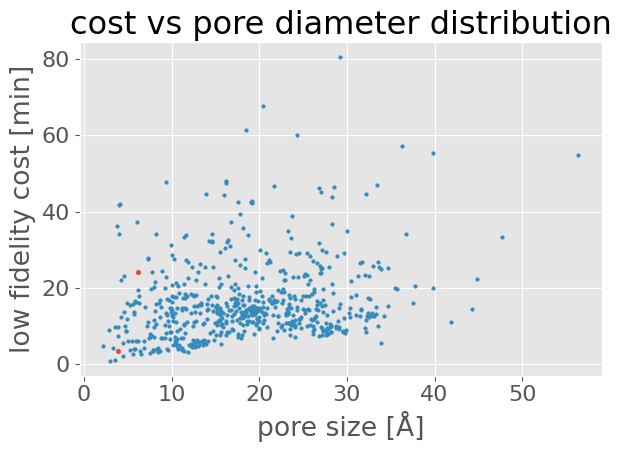

In [13]:
figure()

for name in descriptors[:, "crystal_name"]
    if name in skip_for_now
        continue
    end
    
    pore_dia = descriptors[findfirst(descriptors[:, "crystal_name"] .== name), "pore_diameter_Å"]
    
    henry_time = gr_henry_data[1][findfirst(gr_henry_data[1][:, "xtal"] .== name), "elapsed time (min)"]
    henry_time += gr_henry_data[2][findfirst(gr_henry_data[2][:, "xtal"] .== name), "elapsed time (min)"]
    
    name in benchmarked_cofs ? opt = plot_opt(true) : opt = plot_opt(false)
    scatter(pore_dia, henry_time; opt...)
end

title("cost vs pore diameter distribution")
xlabel("pore size [Å]")
ylabel("low fidelity cost [min]")

tight_layout()

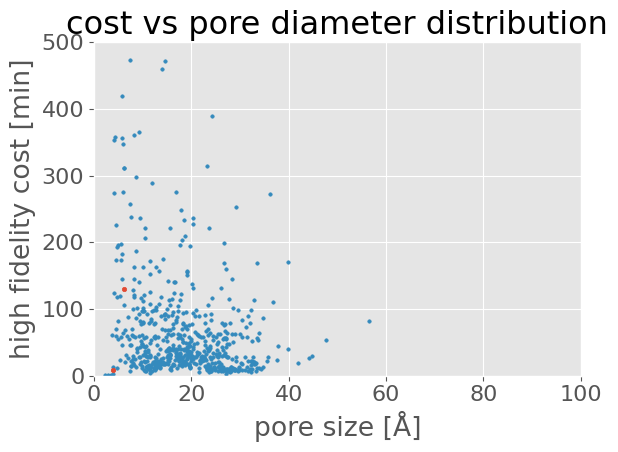

In [14]:
figure()

for name in descriptors[:, "crystal_name"]
    if name in skip_for_now
        continue
    end
    
    pore_dia = descriptors[findfirst(descriptors[:, "crystal_name"] .== name), "pore_diameter_Å"]
    
    gcmc_time = gcmc_data[findfirst(gcmc_data[:, "xtal"] .== name), "elapsed time (min)"]
    
    name in benchmarked_cofs ? opt = plot_opt(true) : opt = plot_opt(false)
    scatter(pore_dia, gcmc_time; opt...)
end

xlim([-0.01, 100])
ylim([-0.01, 500])

title("cost vs pore diameter distribution")
xlabel("pore size [Å]")
ylabel("high fidelity cost [min]")

tight_layout()

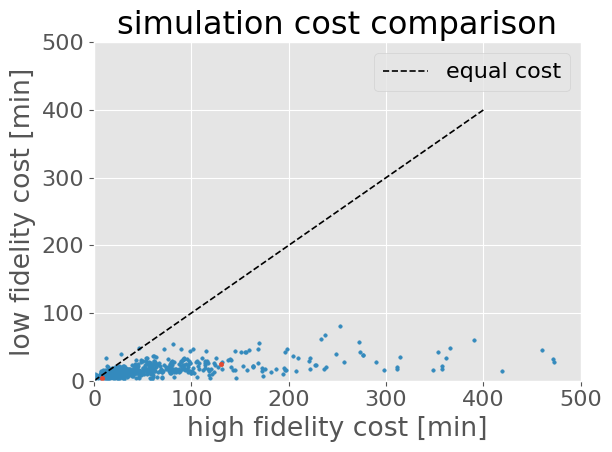

cost ratio: 0.13619402985074627 unfavorable, 0.8638059701492538 favorable


In [22]:
figure()

above = 0
below = 0

for name in descriptors[:, "crystal_name"]
    if name in skip_for_now
        continue
    end
    
    gcmc_time = gcmc_data[findfirst(gcmc_data[:, "xtal"] .== name), "elapsed time (min)"]
    
    henry_time = gr_henry_data[1][findfirst(gr_henry_data[1][:, "xtal"] .== name), "elapsed time (min)"]
    henry_time += gr_henry_data[2][findfirst(gr_henry_data[2][:, "xtal"] .== name), "elapsed time (min)"]
    
    # track fraction above or on the equal cost line
    henry_time >= gcmc_time ? (above += 1) : (below += 1)
    
    name in benchmarked_cofs ? opt = plot_opt(true) : opt = plot_opt(false)
    
    scatter(gcmc_time, henry_time; opt...)
end

cost_ratio = above / below
println("cost ratio: $(cost_ratio) unfavorable, $(1 - cost_ratio) favorable")

# plot the line: y=x
x = range(0.0, stop=400, length=100)
y = x
plot(x, y; label="equal cost", color="k", linestyle="--", linewidth=1.2)

xlim([-0.1, 500.0])
ylim([-0.1, 100.0])
# note: make axis equal

title("simulation cost comparison")
legend()
xlabel("high fidelity cost [min]")
ylabel("low fidelity cost [min]")

tight_layout()